<a href="https://colab.research.google.com/github/ivanadj3/MIEP/blob/main/BreastUltrasoundClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasifikacija ultrazvučnih fotografija raka dojki pomoću neuronske mreže

Rak dojki jedan je od najčešćih uzroka smrti među ženama širom sveta. Rano otkrivanje pomaže prilikom prevencije daljeg pogoršanja. Skup podataka ultrazvuka dojke je kategorisan u tri klase: **normalne**, **benigne** i **maligne** fotografije žena starosti između 25 i 75 godina.

Ovi podaci su prikupljeni 2018. Broj obolelih je 600 pacijenata. Skup se sastoji od 780 slika sa prosečnom veličinom od 500*500 piksela. Slike su u PNG formatu.

Korišćenje neuronskih mreža za treniranje ultrazvučnih slika dojke zahteva primenu tehnika dubokog učenja za automatsko prepoznavanje i klasifikaciju potencijalnih maligniteta.

Neuronska mreža je jedan oblik implementacije sistema veštačke inteligencije, koji predstavlja sistem koji se sastoji od određenog broja međusobno povezanih procesora ili čvorova, ili procesnih elemenata koje nazivamo veštačkim neuronima.

Struktura neuronskih mreža:


1.   Neuroni (čvorovi)
2.   Slojevi
3.   Veze i težine

Ove mreže mogu da nauče složenije reprezentacije podataka jer imaju veću kapacitet za hvatanje i modeliranje složenih obrazaca.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importovanje svih potrebnih biblioteka:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.math import confusion_matrix
import seaborn as sns
tf.random.set_seed(3)

Prikaz fotografija iz različitih kategorija (benignih, malignih i normalnih) u setu podataka za ultrazvučne slike dojke.

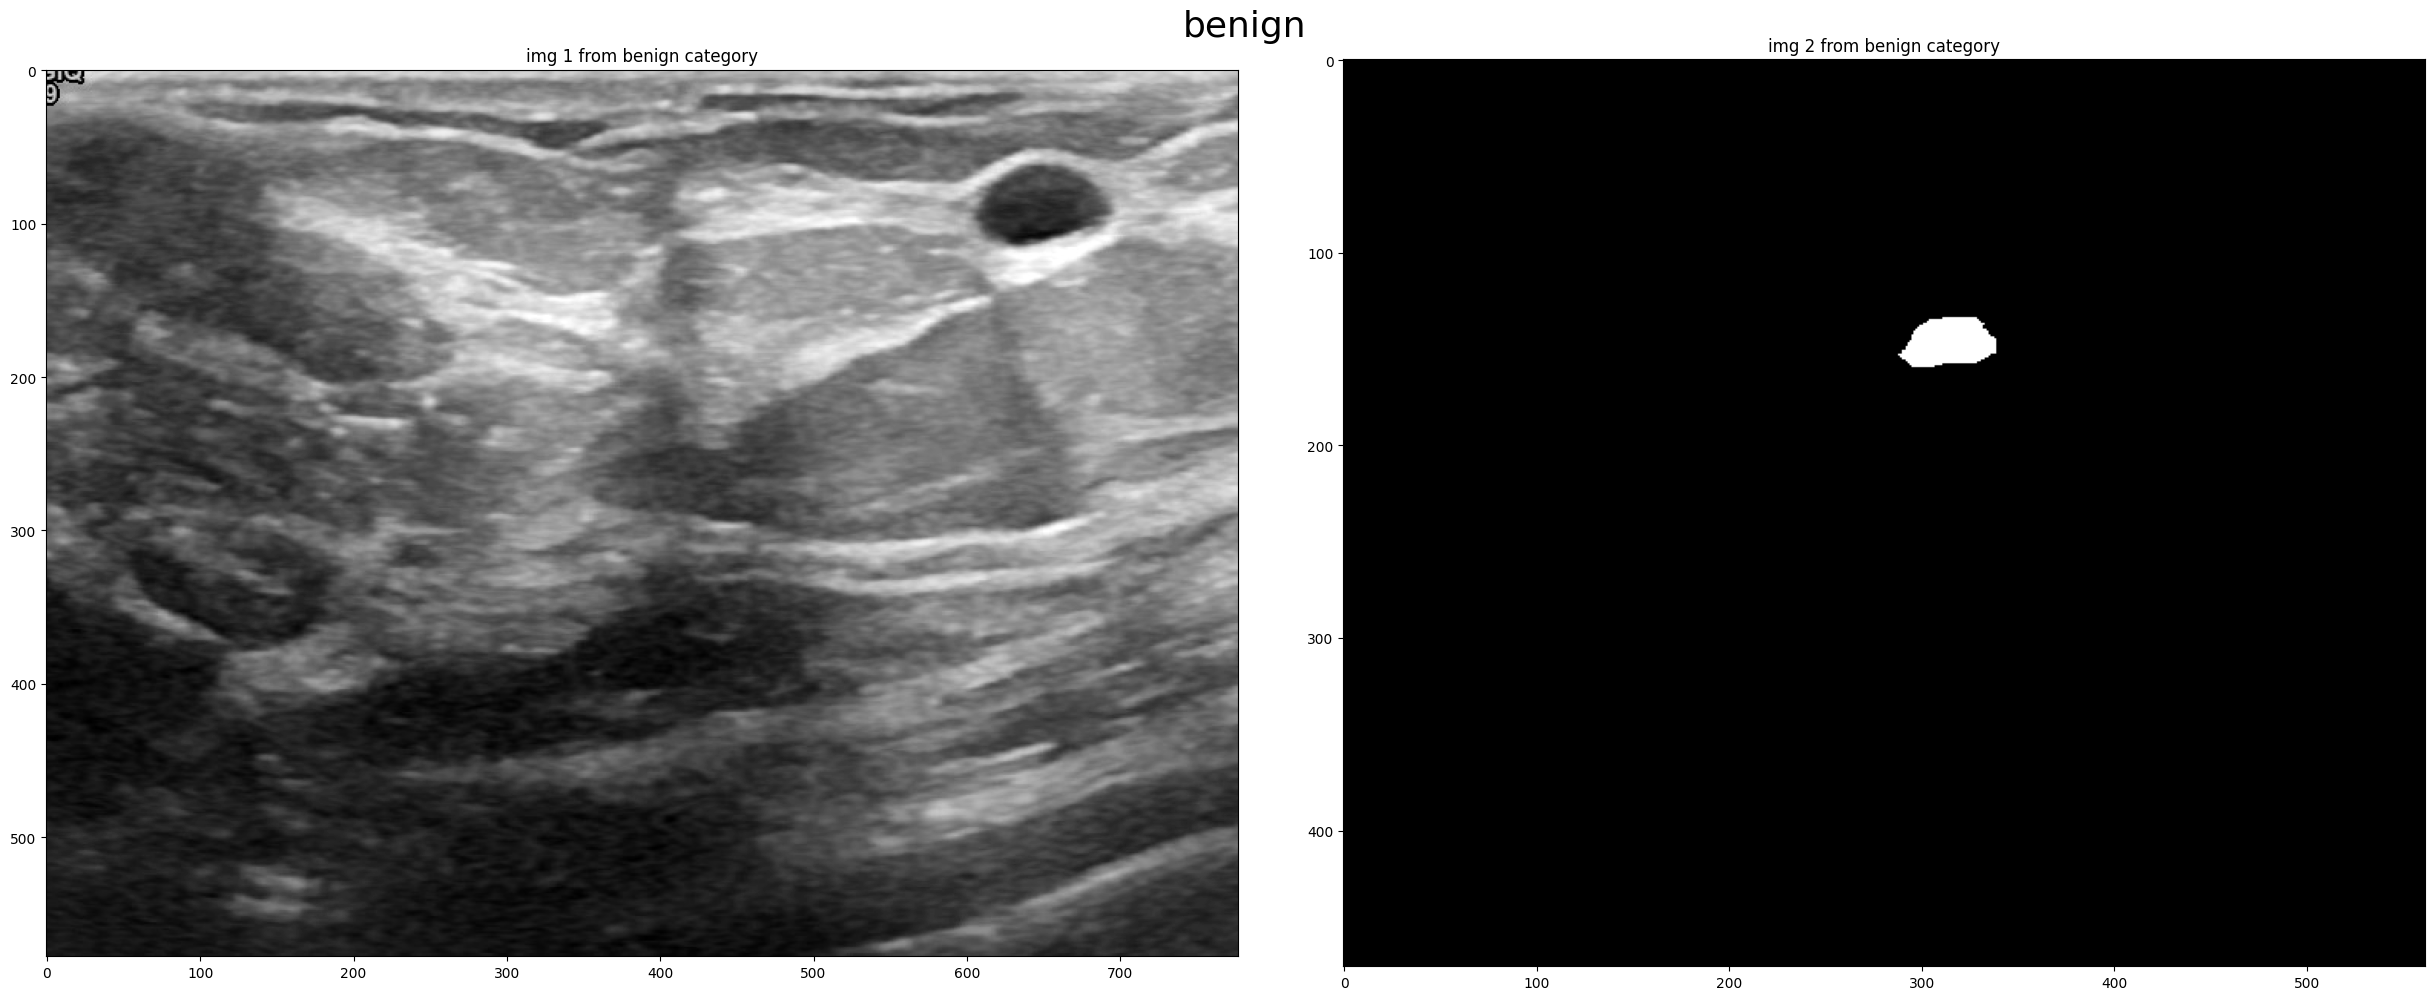

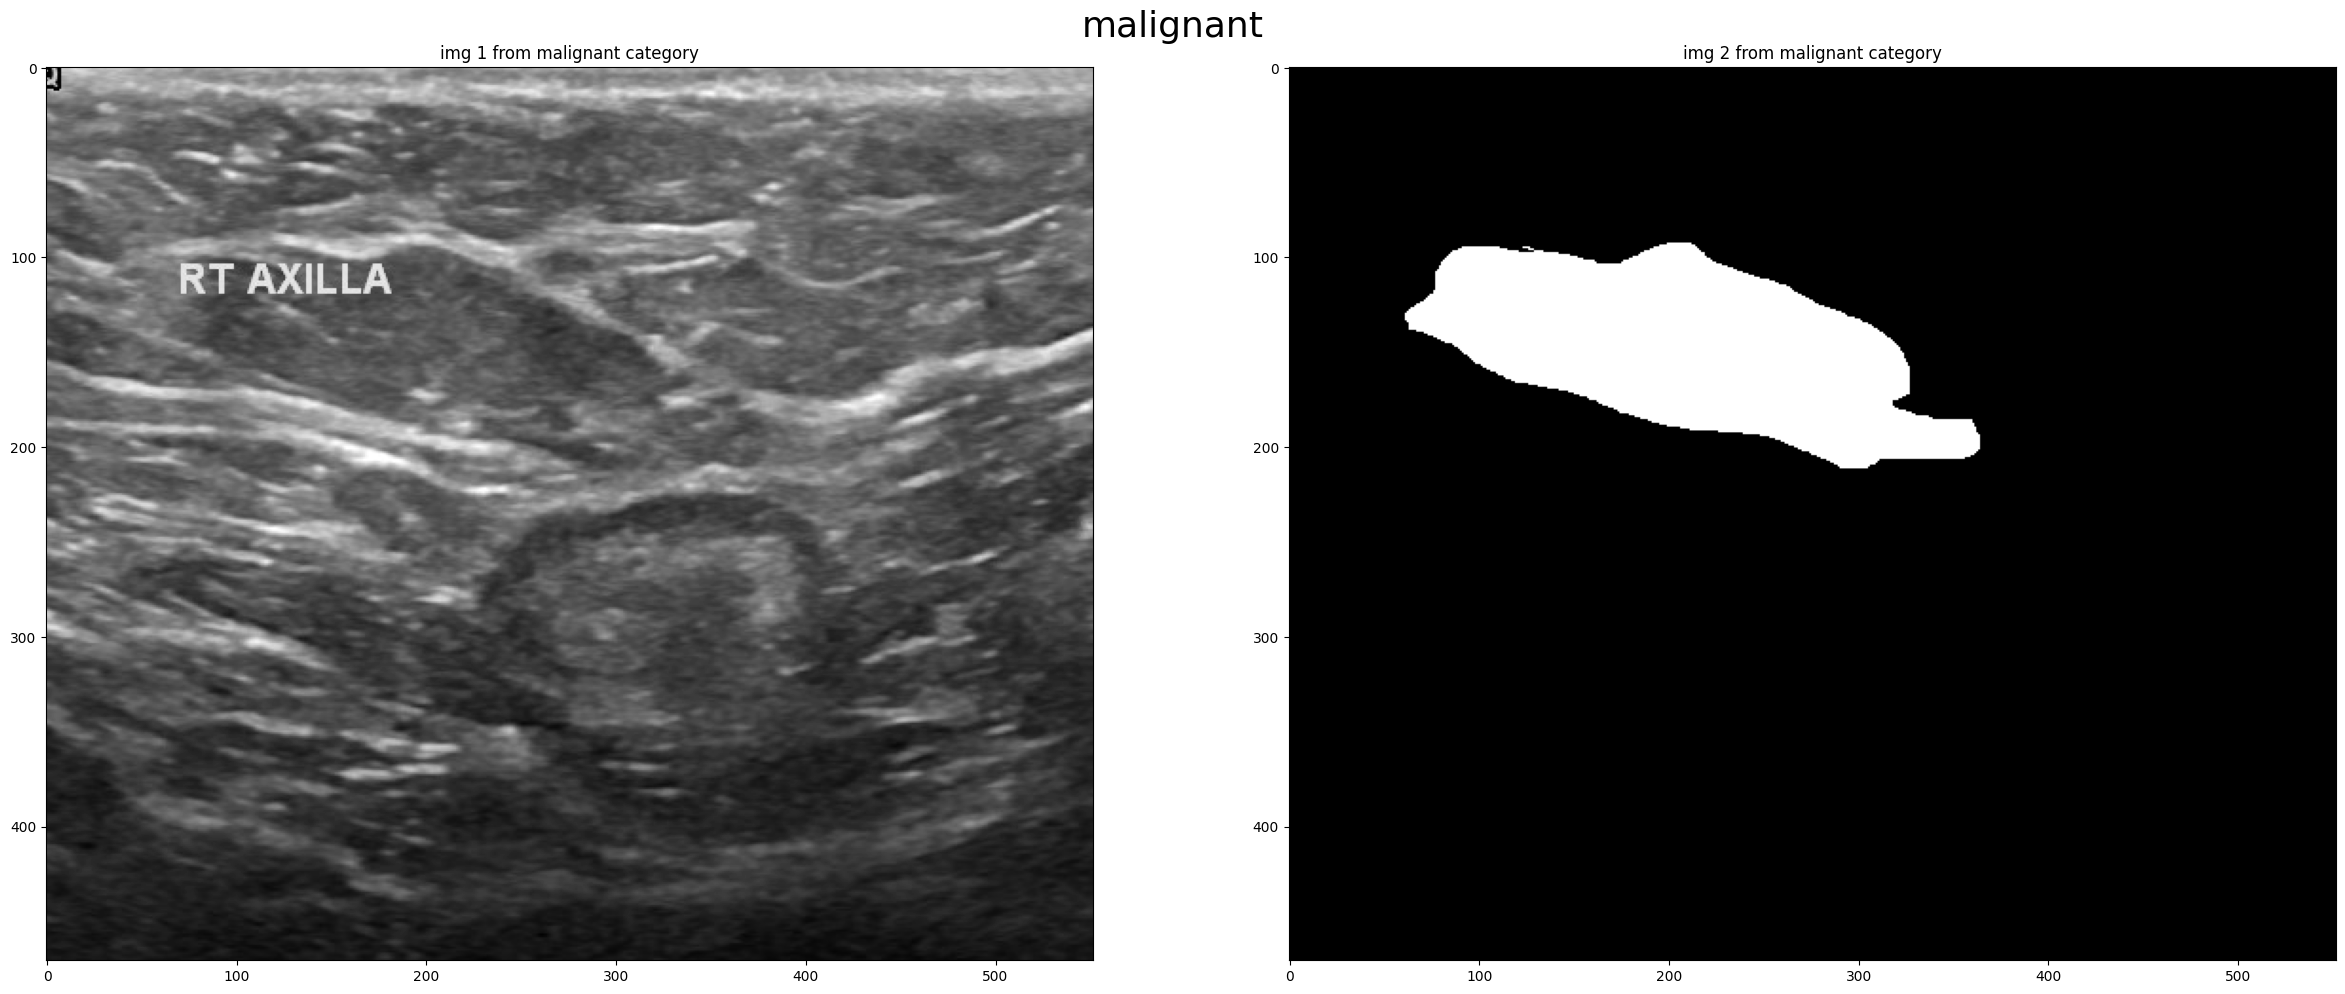

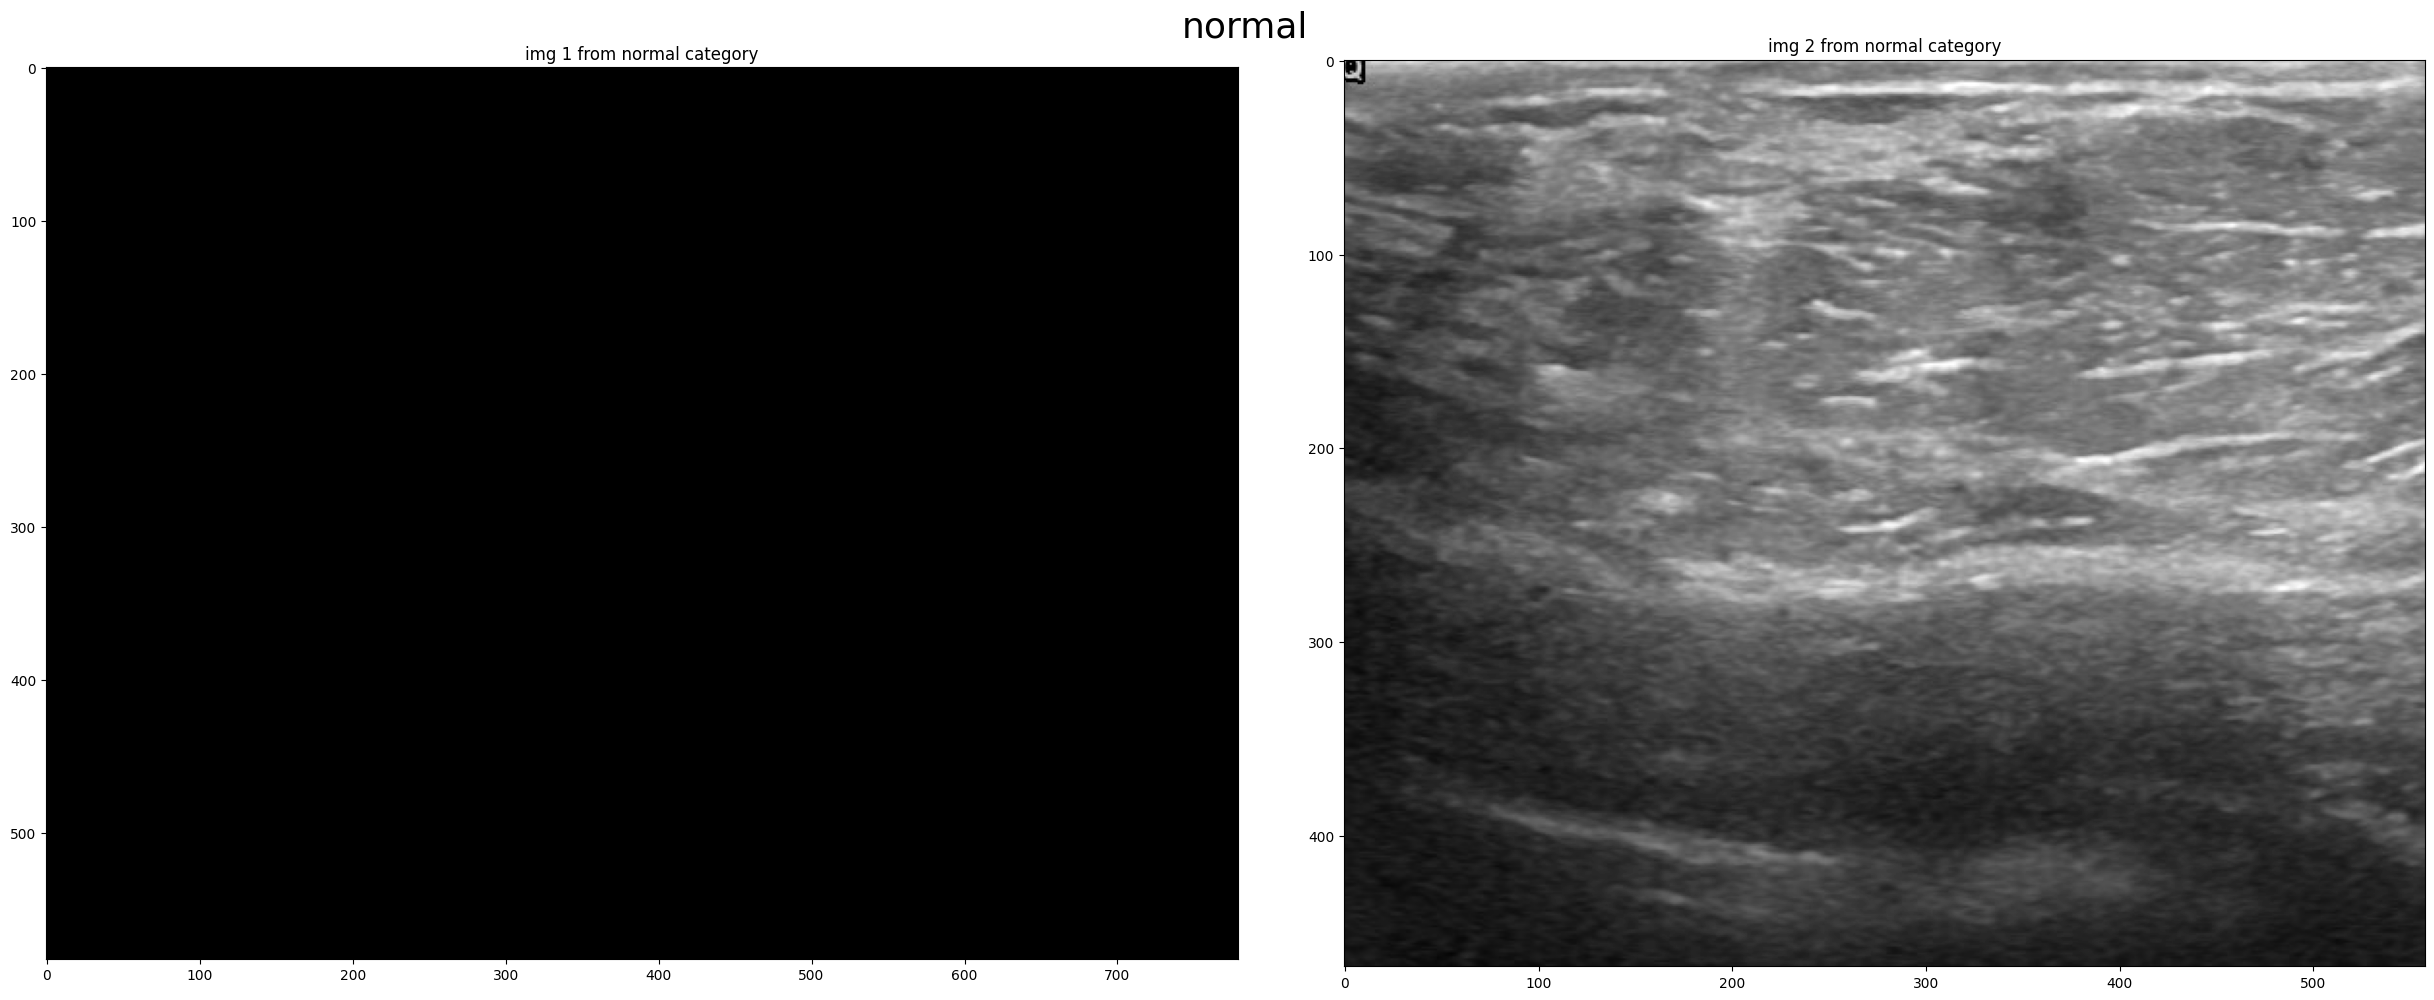

In [3]:
# Definisanje varijabli
folder_name = '/content/drive/MyDrive/BreastUltrasoundImages/Dataset_BUSI_with_GT'
files_names = ['benign', 'malignant', 'normal']

# Iteracija kroz kategorije
for file in files_names:
    path = os.path.join(folder_name, file)
    x = 0
    fig, axes = plt.subplots(1,2, figsize=(25, 10)) # Kreira podgrafikone (subplot) za prikaz dve slike u jednom redu (1 red, 2 kolone), sa veličinom figure (25, 10)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) # Učitava sliku u sivoj skali (grayscale) koristeći OpenCV (cv2.imread)
        axes[x].imshow(img_array, cmap='gray') # imshow prikazuje sliku na odgovarajućem subplotu
        axes[x].set_title(f"img {x+1} from {file} category") # settitle postavlja naslov za svaku sliku, uključujući broj slike i kategoriju
        x += 1
        if x == 2: # Petlja će se prekinuti nakon prikaza dve slike
            break

    plt.suptitle(file, fontsize=26)
    plt.tight_layout()
    plt.show()

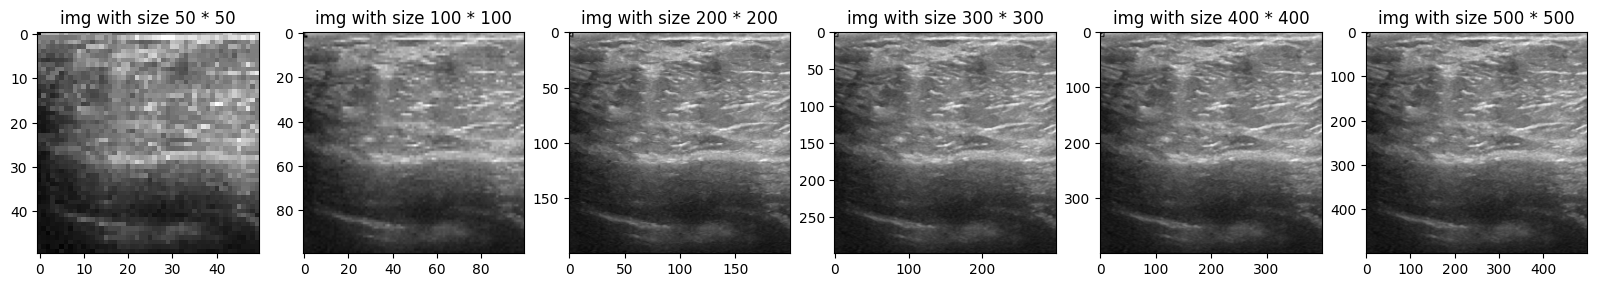

In [4]:
img_sz = [50, 100, 200, 300, 400, 500] # Lista različitih veličina (širina i visina) na koje će se slika promeniti
plt.figure(figsize=(20, 5)) # Postavlja veličinu glavne figure u kojoj će biti prikazane slike

for i, sz in enumerate(img_sz): # Petlja iterira kroz sve vrednosti u img_sz listi
    new_array = cv2.resize(img_array, (sz, sz)) # Menja veličinu img_array slike na sz x sz koristeći OpenCV funkciju cv2.resize
    plt.subplot(1, len(img_sz), i+1) # Kreira subplot (podgrafikon) za svaku promenjenu verziju slike
    plt.imshow(new_array, cmap='gray') # Prikazuje promenu veličine slike na trenutnom subplotu u grayscale
    plt.title(f"img with size {sz} * {sz}") # Postavlja naslov za trenutni subplot, navodeći dimenzije promene veličine slike

plt.show()

In [5]:
# Veličina 300x300 je u redu
img_sz=300

Učitavanje i pripremanje podataka, tako što se pre svega vrši inicijalizacija prazne liste training_data za podatke za treniranje.

Želimo da funkcija create_training_data iterira kroz svaku kategoriju (benign, malignant, normal), ispiše naziv trenutne kategorije i njen odgovarajući indeks klase.

In [6]:
training_data = []

def create_training_data():
    for file in files_names:
        path = os.path.join(folder_name, file) # path kombinuje glavnu putanju sa imenom trenutne kategorije da bi se dobila potpuna putanja do foldera sa slikama za tu kategoriju
        class_num = files_names.index(file) # class_num dobija indeks trenutne kategorije iz liste files_names
        print(file,class_num)

        for img in tqdm(os.listdir(path)): # Iterira kroz sve slike u trenutnom folderu kategorije, koristeći tqdm za prikazivanje napretka iteracije
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array, (img_sz, img_sz))  # Menja veličinu slike na dimenzije (img_sz, img_sz) koristeći cv2.resize
            training_data.append([new_array, class_num]) # Dodaje listu koja sadrži promenjenu veličinu slike (new_array) i odgovarajući indeks klase (class_num) u training_data listu

create_training_data() # Definiše praznu listu training_data, definiše funkciju create_training_data() i na kraju je poziva da popuni listu sa pripremljenim podacima za treniranje

benign 0


100%|██████████| 891/891 [00:40<00:00, 22.22it/s]


malignant 1


100%|██████████| 421/421 [00:11<00:00, 36.55it/s]


normal 2


100%|██████████| 266/266 [00:06<00:00, 43.64it/s]


Prikazuje klase za prvih 5 fotografija:

In [7]:
for i in range(5):
    print("Class number for image", i+1, ":", training_data[i][1])

Class number for image 1 : 0
Class number for image 2 : 0
Class number for image 3 : 0
Class number for image 4 : 0
Class number for image 5 : 0


Prikazuje klase za poslednjih 5 fotografija:

In [8]:
for i in range(-1, -6, -1): #  Iterira od -1 do -5 (uključujući) sa korakom -1. To znači da iterira unazad kroz poslednjih pet elemenata liste
    print("Class number for image", len(training_data) + i + 1, ":", training_data[i][1])

Class number for image 1578 : 2
Class number for image 1577 : 2
Class number for image 1576 : 2
Class number for image 1575 : 2
Class number for image 1574 : 2


Mešanje podataka:

Mešanje podataka (shuffle) je jako bitan korak u pripremi podataka za treniranje mašinskih modela iz nekoliko razloga:


1.  **Smanjenje pristrasnosti (bias)**

Ako su podaci organizovani po kategorijama (npr. prvo sve benigne, zatim sve maligne, pa normalne slike), model može naučiti redosled umesto stvarnih karakteristika koje razdvajaju klase. Mešanje osigurava da model vidi sve vrste podataka tokom treniranja, što pomaže u boljem generalizovanju.

2.  **Bolje treniranje**

Kada se podaci ne mešaju, model može da se pretrenirava (overfit) na specifične delove podataka. Mešanje pomaže da model vidi različite uzorke u različitim iteracijama treniranja, što poboljšava njegovu sposobnost da uči iz celokupnog skupa podataka.

3.  **Validacija**

Ako se podaci dele na trening i test skupove bez mešanja, može se desiti da svi podaci iz jedne klase završe u jednom skupu, što nije poželjno. Mešanje pre deljenja osigurava da su podaci iz svih klasa prisutni u oba skupa.

In [9]:
random.shuffle(training_data)

for i in range(30):
    print(f"Sample {i+1}:")
    print("Class number:", training_data[i][1],"\n")

Sample 1:
Class number: 0 

Sample 2:
Class number: 0 

Sample 3:
Class number: 0 

Sample 4:
Class number: 0 

Sample 5:
Class number: 0 

Sample 6:
Class number: 0 

Sample 7:
Class number: 2 

Sample 8:
Class number: 1 

Sample 9:
Class number: 0 

Sample 10:
Class number: 1 

Sample 11:
Class number: 0 

Sample 12:
Class number: 0 

Sample 13:
Class number: 0 

Sample 14:
Class number: 1 

Sample 15:
Class number: 2 

Sample 16:
Class number: 2 

Sample 17:
Class number: 1 

Sample 18:
Class number: 0 

Sample 19:
Class number: 0 

Sample 20:
Class number: 0 

Sample 21:
Class number: 0 

Sample 22:
Class number: 0 

Sample 23:
Class number: 0 

Sample 24:
Class number: 1 

Sample 25:
Class number: 1 

Sample 26:
Class number: 0 

Sample 27:
Class number: 1 

Sample 28:
Class number: 0 

Sample 29:
Class number: 1 

Sample 30:
Class number: 0 



In [10]:
X=[] # Kreiranje praznih listi X[] i y[]
y=[]

for feature,label in training_data:
    X.append(feature) # Dodaje sliku (feature) u listu X
    y.append(label) # Dodaje oznaku klase (label) u listu y

X=np.array(X)
y=np.array(y)

Pretvaranje listi u numpy nizove

In [11]:
X=np.array(X)
y=np.array(y)

# Provera oblika (dimenzija) nizova

print(X.shape)
print(y.shape)

(1578, 300, 300)
(1578,)


In [12]:
# Podela podataka na trening i test skupove

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # test_size=0.2 znači da će 20% podataka biti u test skupu, a random_state=42 osigurava da je podela replikabilna (uvek ista podela).

# Provera oblika trening i test skupova

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1262, 300, 300)
(1262,)
(316, 300, 300)
(316,)


In [13]:
print(np.unique(y_train)) # Ispisuje jedinstvene oznake klasa u trening skupu

print(np.unique(y_test)) # Ispisuje jedinstvene oznake klasa u test skupu

[0 1 2]
[0 1 2]


**Normalizacija slika**:

Normalizacija pomaže u stabilizaciji i ubrzanju treniranja modela tako što skalira vrednosti piksela u slike na određeni opseg, obično između 0 i 1.
Deljenjem sa 255, pikseli slika se skaliraju na opseg [0, 1].

Vrednosti piksela su u opsegu od 0 do 255, gde 0 predstavlja crnu boju, a 255 belu boju, s tim da su vrednosti između nijanse sive.

Normalizaciju radimo iz nekoliko razloga, a neki od njih su:

1.   **Stabilizacija treniranja**: Kada se koriste neuronske mreže, posebno one sa više slojeva, velike vrednosti piksela mogu uzrokovati da gradijenti postanu preveliki ili premali, što može destabilizovati proces treniranja.
2.   **Ubrzanje konvergencije**: Normalizovani podaci omogućavaju brže učenje modela, jer sve vrednosti ulaza imaju sličan opseg.
3.   **Poboljšanje performansi**: Modeli koji rade sa normalizovanim podacima često postižu bolje performanse jer su vrednosti konzistentnije.

In [14]:
X_train = X_train/255
X_test = X_test/255

In [15]:
print(X_train[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


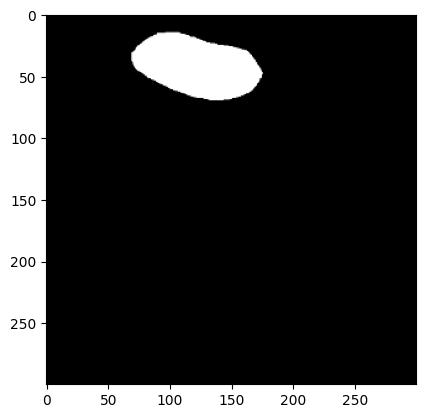

In [16]:
plt.imshow(X_train[0],cmap='gray')
plt.show()

Definisanje sekvencijalnog modela:

In [17]:
model = keras.Sequential([
                          keras.layers.Flatten(input_shape=(img_sz,img_sz)), # Prvi sloj je Flatten sloj koji pretvara 2D ulazne slike u 1D niz
                          keras.layers.Dense(256, activation='relu'), # Dense (potpuno povezan) sloj sa 256 neurona i ReLU aktivacijom. Sledi nekoliko drugih Dense slojeva sa sve manjim brojem neurona.
                          keras.layers.Dense(128, activation='relu'),
                          keras.layers.Dense(64, activation='relu'),
                          keras.layers.Dense(32, activation='relu'),
                          keras.layers.Dense(16, activation='relu'),
                          keras.layers.Dense(8, activation='relu'),
                          keras.layers.Dense(3, activation='sigmoid') # Izlazni sloj sa 3 neurona (jedan za svaku klasu) i sigmoidnom aktivacijom.
])

Kompajliranje modela:

In [18]:
model.compile(optimizer='adam', # Koristi adam optimizator
              loss = 'sparse_categorical_crossentropy', # Koristi sparse categorical crossentropy kao funkciju gubitka, koja je pogodna za multi-klasne probleme sa integer oznakama.
              metrics=['accuracy'])

In [19]:
history=model.fit(X_train, y_train, epochs=15,validation_split=0.1)

Epoch 1/15
36/36 [==============================] - 26s 627ms/step - loss: 1.4657 - accuracy: 0.5436 - val_loss: 0.9948 - val_accuracy: 0.5669
Epoch 2/15
36/36 [==============================] - 22s 594ms/step - loss: 1.0147 - accuracy: 0.6176 - val_loss: 1.0646 - val_accuracy: 0.5906
Epoch 3/15
36/36 [==============================] - 19s 539ms/step - loss: 0.8197 - accuracy: 0.6952 - val_loss: 0.9474 - val_accuracy: 0.6457
Epoch 4/15
36/36 [==============================] - 19s 531ms/step - loss: 0.6809 - accuracy: 0.7181 - val_loss: 0.8827 - val_accuracy: 0.5906
Epoch 5/15
36/36 [==============================] - 27s 767ms/step - loss: 0.6175 - accuracy: 0.7251 - val_loss: 1.0799 - val_accuracy: 0.6142
Epoch 6/15
36/36 [==============================] - 44s 1s/step - loss: 0.6138 - accuracy: 0.7401 - val_loss: 0.8537 - val_accuracy: 0.6614
Epoch 7/15
36/36 [==============================] - 26s 722ms/step - loss: 0.6042 - accuracy: 0.7709 - val_loss: 0.9634 - val_accuracy: 0.6614
Ep

Ispisivanje sažetka modela:

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 90000)             0         
                                                                 
 dense (Dense)               (None, 256)               23040256  
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 8)                 1

Evaluacija modela na test podacima:

In [21]:
loss, accuracy = model.evaluate(X_test, y_test) # Evaluira model na test podacima i vraća gubitak i tačnost
print(f"Accuarcy of the model is : {accuracy*100:.2f} %")

10/10 [==============================] - 1s 92ms/step - loss: 0.9054 - accuracy: 0.7342
Accuarcy of the model is : 73.42 %


Predikcije na test podacima:

In [22]:
y_pred=model.predict(X_test) # Pravi predikcije za test podatke
print(y_pred[0]) # Ispisuje prve predikcije za test podatke

10/10 [==============================] - 1s 58ms/step
[0.99970084 0.9949614  0.99919766]


In [23]:
y_pred = [np.argmax(i) for i in y_pred]
print(y_pred)

[0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 2, 0, 1, 0, 1, 2, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 0, 0, 1, 1, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 1, 2, 0, 2, 0, 2, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 2, 0, 1, 1, 0, 1, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 2, 0, 2, 2, 1, 0, 1, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


Kreiranje DataFrame-a za poređenje stvarnih i predikovanih vrednosti:

In [24]:
comparison_df = pd.DataFrame({ 'Actual': y_test,'Predicted': y_pred})

print(comparison_df[:20])

    Actual  Predicted
0        2          0
1        1          0
2        1          1
3        2          2
4        0          0
5        0          0
6        0          0
7        1          0
8        0          0
9        0          0
10       0          0
11       1          1
12       0          0
13       1          1
14       0          0
15       0          1
16       0          0
17       0          0
18       0          0
19       0          0


Izrada matrice konfuzije:

In [25]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

tf.Tensor(
[[159  16   6]
 [ 52  29   0]
 [ 14   0  40]], shape=(3, 3), dtype=int32)


Text(0.5, 47.7222222222222, 'Predicted Labels')

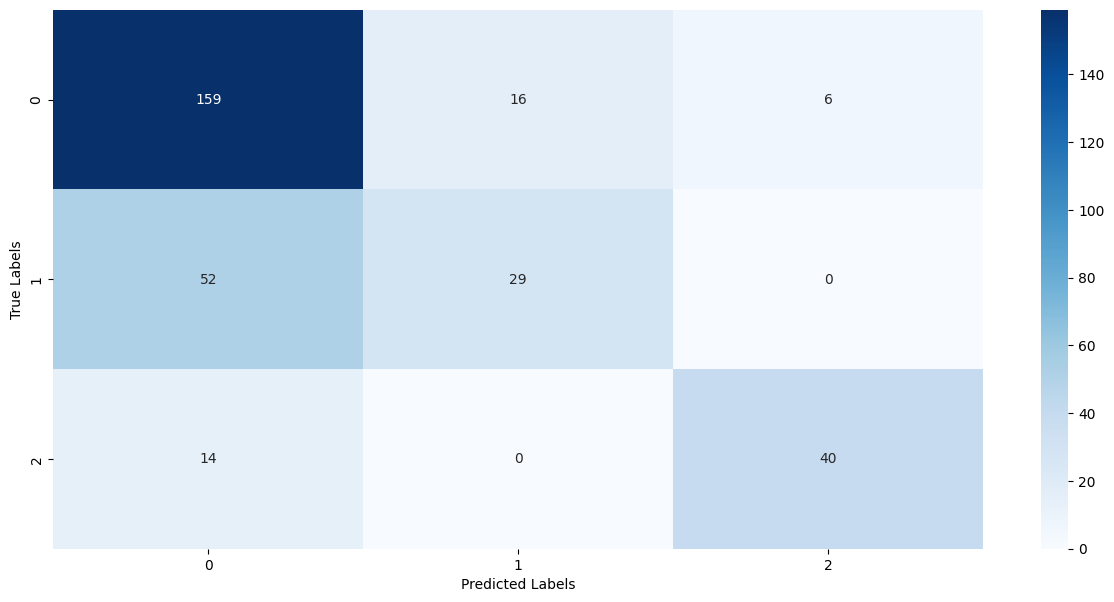

In [26]:
plt.figure(figsize=(15,7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels') # Postavlja oznaku y-ose
plt.xlabel('Predicted Labels') # Postavlja oznaku x-ose

In [27]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.88      0.78       181
           1       0.64      0.36      0.46        81
           2       0.87      0.74      0.80        54

    accuracy                           0.72       316
   macro avg       0.74      0.66      0.68       316
weighted avg       0.72      0.72      0.70       316

